In [289]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from PIL import Image
import os
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [153]:
def load_image(url, angle=0): 
    image = Image.open(url).rotate(angle)
    image = np.array(image)
    image = image / 255
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image).float()
    return image

In [154]:
train_x = [load_image(f'Resized_Dataset\\train\\{i}') for i in os.listdir("Resized_Dataset\\train")]
train_y = [0 if (i.split('_')[1])=="healthy.jpg" else 1 for i in os.listdir("Resized_Dataset\\train")]
test_x = [load_image(f'Resized_Dataset\\test\\{i}') for i in os.listdir("Resized_Dataset\\test")]
test_y = [0 if (i.split('_')[1])=="healthy.jpg" else 1 for i in os.listdir("Resized_Dataset\\test")]
print(len(train_x), len(train_y), len(test_x), len(test_y))
#train_x = [load_image(f') for i in range(1, 50001)]

160 160 40 40


In [155]:
train_x = torch.stack(train_x)
train_y = torch.tensor(train_y)

test_x = torch.stack(test_x)
test_y = torch.tensor(test_y)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([160, 3, 224, 224]) torch.Size([160]) torch.Size([40, 3, 224, 224]) torch.Size([40])


In [177]:
# Making Dataloader
batch_size = 16
train_data = TensorDataset(train_x, train_y)
test_data = TensorDataset(test_x, test_y)
torch.manual_seed(42)               # Set seed for reproducibility
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=40, shuffle=True)


In [297]:
class VGG1(nn.Module):
    def __init__(self):
        super(VGG1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(10*112*112, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out
    
class VGG3(nn.Module):
    def __init__(self):
        super(VGG3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*28*28, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        out = self.conv(x)
        out = self.mlp(out)
        return out
    
class VGG4(nn.Module):
    def __init__(self):
        super(VGG4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(10*14*14, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out
    

class VGG2(nn.Module):
    def __init__(self):
        super(VGG2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*56*56, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        out = self.conv(x)
        out = self.mlp(out)
        return out
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),

            nn.Linear(4096, 1000),
            nn.ReLU(),

            nn.Linear(1000, num_classes)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out



In [298]:
# Calculate Accuracy
def accuracy(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float().flatten()
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total
        #print('Test Accuracy of the model on the 40 test images: {} %'.format(100 * correct / total))


In [303]:
model = VGG2().to(device)
test_acc = []

In [304]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [305]:
print(len(train_loader))

10


In [306]:
# Train the model
total_step = len(train_loader)
num_epochs =80
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 5 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    # Test
    test_acc.append(accuracy(model, test_loader))

Epoch [1/80], Step [5/10], Loss: 0.6576
Epoch [1/80], Step [10/10], Loss: 0.6722
Epoch [2/80], Step [5/10], Loss: 0.6775
Epoch [2/80], Step [10/10], Loss: 0.7064
Epoch [3/80], Step [5/10], Loss: 0.6819
Epoch [3/80], Step [10/10], Loss: 0.6887
Epoch [4/80], Step [5/10], Loss: 0.6904
Epoch [4/80], Step [10/10], Loss: 0.6926
Epoch [5/80], Step [5/10], Loss: 0.6898
Epoch [5/80], Step [10/10], Loss: 0.6967
Epoch [6/80], Step [5/10], Loss: 0.6840
Epoch [6/80], Step [10/10], Loss: 0.7015
Epoch [7/80], Step [5/10], Loss: 0.6876
Epoch [7/80], Step [10/10], Loss: 0.6921
Epoch [8/80], Step [5/10], Loss: 0.6943
Epoch [8/80], Step [10/10], Loss: 0.6817
Epoch [9/80], Step [5/10], Loss: 0.6997
Epoch [9/80], Step [10/10], Loss: 0.6797
Epoch [10/80], Step [5/10], Loss: 0.6914
Epoch [10/80], Step [10/10], Loss: 0.6880
Epoch [11/80], Step [5/10], Loss: 0.6807
Epoch [11/80], Step [10/10], Loss: 0.6893
Epoch [12/80], Step [5/10], Loss: 0.6812
Epoch [12/80], Step [10/10], Loss: 0.6794
Epoch [13/80], Step [5

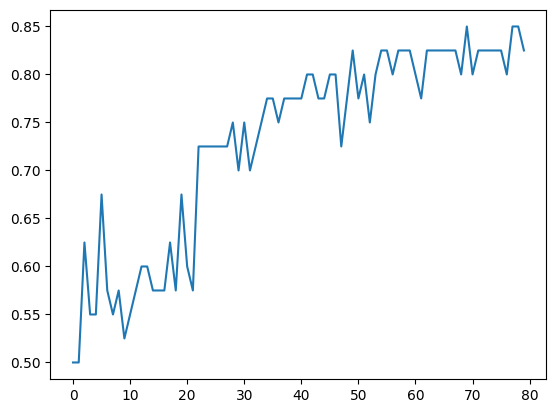

In [307]:
plt.plot(test_acc)

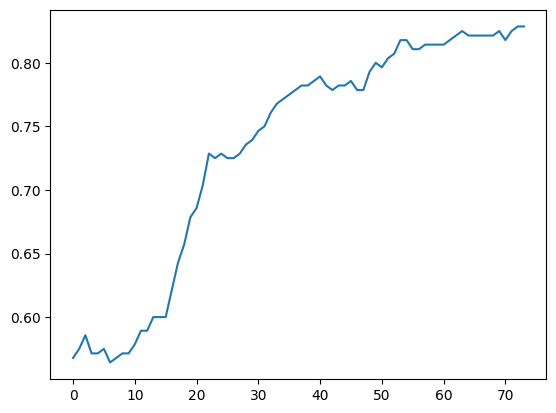

In [310]:
# Smoothing out the curve for better visualization
smoothed = []
for i in range(3, len(test_acc)-3):
    smoothed.append(sum(test_acc[i-3:i+4])/7)
plt.plot(smoothed)

In [308]:
print('Test Accuracy of the model on the 40 test images: {} %'.format(100 * accuracy(model, test_loader)))

Test Accuracy of the model on the 40 test images: 82.5 %


Predicted: 1, Actual: 0
101_healthy.jpg


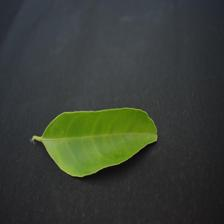


Predicted: 1, Actual: 0
118_healthy.jpg


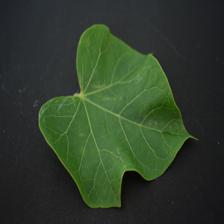


Predicted: 1, Actual: 0
158_healthy.jpg


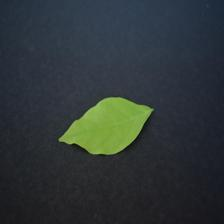


Predicted: 0, Actual: 1
178_diseased.jpg


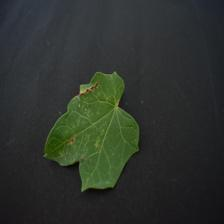


Predicted: 1, Actual: 0
85_healthy.jpg


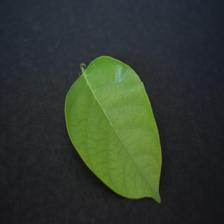


Predicted: 1, Actual: 0
86_healthy.jpg


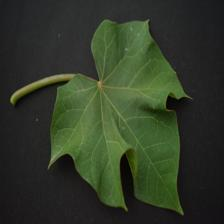


Predicted: 1, Actual: 0
91_healthy.jpg


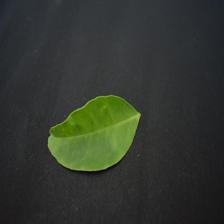

In [309]:
# Let us view the miscassified images
test_paths = os.listdir("Resized_Dataset\\test")
model.eval()
for path in test_paths:
    image = load_image(f'Resized_Dataset\\test\\{path}').unsqueeze(0).to(device)
    label = 0 if (path.split('_')[1])=="healthy.jpg" else 1
    output = model(image)
    predicted = (torch.sigmoid(output) > 0.5).float().item()
    if predicted != label:
        print(f"Predicted: {int(predicted)}, Actual: {label}")
        print(path)
        display(Image.open(f'Resized_Dataset\\test\\{path}'))
        print("")



In [311]:
# Finding the number of parameters of model using numel
print(sum(p.numel() for p in model.parameters()))


314811


In [131]:
# Augmenting the data so as to increase the size of the dataset
aug_train_x = [load_image(f'Resized_Dataset\\train\\{i}', ang) for ang in [0, 90, 180, 270] for i in os.listdir("Resized_Dataset\\train")]
aug_train_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for _ in range(4) for i in os.listdir("Resized_Dataset\\train")]
aug_train_x = torch.stack(aug_train_x)
aug_train_y = torch.tensor(aug_train_y)

In [135]:
# Making Dataloader
batch_size = 16
aug_train_data = torch.utils.data.TensorDataset(aug_train_x, aug_train_y)
torch.manual_seed(42)               # Set seed for reproducibility
aug_train_loader = torch.utils.data.DataLoader(aug_train_data, batch_size=batch_size, shuffle=True)

In [136]:
aug_model = VGG3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(aug_model.parameters(), lr=0.0001)

In [137]:
# Train the model
total_step = len(aug_train_loader)
num_epochs = 60
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(aug_train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = aug_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/60], Step [1/40], Loss: 0.6468
Epoch [1/60], Step [2/40], Loss: 0.8020
Epoch [1/60], Step [3/40], Loss: 0.7911
Epoch [1/60], Step [4/40], Loss: 0.6580
Epoch [1/60], Step [5/40], Loss: 0.7051
Epoch [1/60], Step [6/40], Loss: 0.7350
Epoch [1/60], Step [7/40], Loss: 0.7502
Epoch [1/60], Step [8/40], Loss: 0.6900
Epoch [1/60], Step [9/40], Loss: 0.6524
Epoch [1/60], Step [10/40], Loss: 0.7018
Epoch [1/60], Step [11/40], Loss: 0.8017
Epoch [1/60], Step [12/40], Loss: 0.6633
Epoch [1/60], Step [13/40], Loss: 0.6491
Epoch [1/60], Step [14/40], Loss: 0.5463
Epoch [1/60], Step [15/40], Loss: 0.7988
Epoch [1/60], Step [16/40], Loss: 0.6515
Epoch [1/60], Step [17/40], Loss: 0.7159
Epoch [1/60], Step [18/40], Loss: 0.7338
Epoch [1/60], Step [19/40], Loss: 0.6829
Epoch [1/60], Step [20/40], Loss: 0.6516
Epoch [1/60], Step [21/40], Loss: 0.7606
Epoch [1/60], Step [22/40], Loss: 0.5743
Epoch [1/60], Step [23/40], Loss: 0.7031
Epoch [1/60], Step [24/40], Loss: 0.6824
Epoch [1/60], Step [25/40

Predicted: 1, Actual: 0
137_healthy.jpg


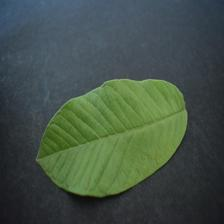


Predicted: 1, Actual: 0
158_healthy.jpg


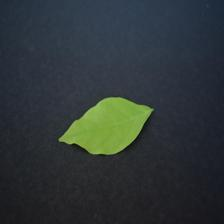


Predicted: 0, Actual: 1
182_diseased.jpg


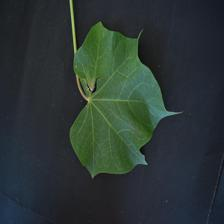


Predicted: 1, Actual: 0
186_healthy.jpg


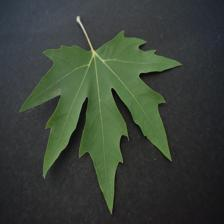


Predicted: 1, Actual: 0
22_healthy.jpg


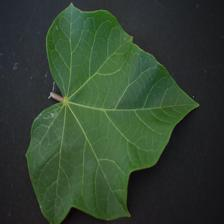


Predicted: 1, Actual: 0
23_healthy.jpg


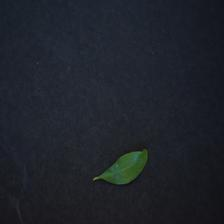


Predicted: 0, Actual: 1
46_diseased.jpg


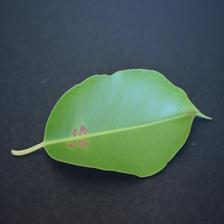

In [138]:
# Let us view the miscassified images
test_paths = os.listdir("Resized_Dataset\\test")
aug_model.eval()
for path in test_paths:
    image = load_image(f'Resized_Dataset\\test\\{path}').unsqueeze(0).to(device)
    label = 0 if (path.split('_')[1])=="healthy.jpg" else 1
    output = aug_model(image)
    _, predicted = torch.max(output.data, 1)
    if predicted != label:
        print(f"Predicted: {predicted.item()}, Actual: {label}")
        print(path)
        display(Image.open(f'Resized_Dataset\\test\\{path}'))
        print("")

In [312]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False


vgg16.classifier[6] = nn.Linear(in_features=20, out_features=1)
optimizer = torch.optim.Adam(vgg16.classifier[6].parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()



c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Rajeev Wankar/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:12<00:00, 7.63MB/s] 
